In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Capstone_Project"
!ls

/content/drive/MyDrive/Capstone_Project
 annotations
 checkpoints
'COCO_train2014_000000581909 (1).jpg'
 COCO_train2014_000000581909.jpg
 error
 image_captioning_3_model_train_test_mscoco2014_10k_data.ipynb
 image_captioning_3_model_train_test_mscoco2014_1k_data.ipynb
 image_captioning_3_model_train_test_mscoco2014_20k_data_100_epoch.ipynb
 image_captioning_3_model_train_test_mscoco2014_20k_data_150_epoch.ipynb
 image_captioning_3_model_train_test_mscoco2014_20k_data_300_epoch.ipynb
 image_captioning_3_model_train_test_mscoco2014_20k_data_50_epoch.ipynb
 image_captioning_3_model_train_test_mscoco2014_20k_data.ipynb
 image_captioning_3_model_train_test_mscoco2014_50k_data.ipynb
 image_captioning_load_model_text_similarity_v2.ipynb
 image_captioning_load_model_text_similarity_v3.ipynb
 materials
 nlp_models
 old
 output_10k
 output_1k
 output_20k
 output_20k_100_epoch
 output_20k_150_epoch
 output_20k_20_epoch
 output_20k_300_epoch
 output_20k_50_epoch
 output_50k
 output_nlp
 sentence_s

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

print(np.__version__)
print(tf.version.VERSION)

1.21.5
2.8.0


In [ ]:
encoder_loaded = tf.saved_model.load('output_20k_150_epoch/encoder_model')
decoder_loaded = tf.saved_model.load('output_20k_150_epoch/decoder_model')

In [ ]:
max_length = 50
attention_features_shape = 64

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow
import pickle

from_disk = pickle.load(open("output_20k_150_epoch/tokenizer.pickle", "rb"))
tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
tokenizer.set_weights(from_disk['weights'])

# # Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

87924736/87910968 [==============================] - 4s 0us/step


In [ ]:
def evaluate_loaded(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # hidden = decoder_loaded.reset_state(batch_size=1)
    hidden =  tf.zeros((1, 512))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder_loaded(img_tensor_val)
    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder_loaded(dec_input,
                                                         features,
                                                         hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
        dec_input = tf.cast(dec_input, tf.int64)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# https://medium.com/@rk.sarthak01/how-to-import-files-images-in-google-colab-from-your-local-system-46a801b1e568
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

uploaded = files.upload()

# print(list(uploaded.keys()))

image_file = list(uploaded.keys())[0]
image_path = os.path.abspath('.') + "/" + image_file
print(image_path)

Saving COCO_train2014_000000581909.jpg to COCO_train2014_000000581909 (2).jpg
/content/drive/MyDrive/Capstone_Project/COCO_train2014_000000581909.jpg


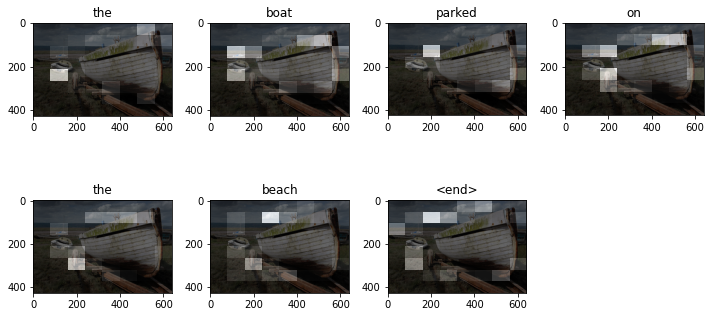

Predicted Caption: the boat parked on the beach


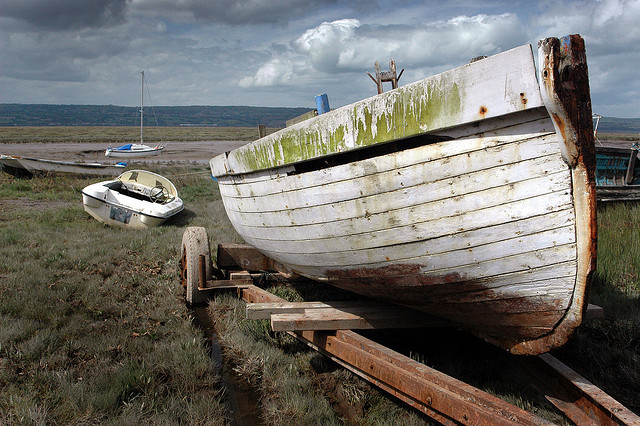

In [ ]:
result, attention_plot = evaluate_loaded(image_path)
plot_attention(image_path, result, attention_plot)
output = ' '.join(result[:-1])
print(f"Predicted Caption: {output}")

# opening the image
Image.open(image_path)

# Text Similarity using Multiple Models

In [ ]:
!pip install -q sentence_transformers

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 23.9 MB/s 
     |████████████████████████████████| 1.2 MB 85.6 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 895 kB 85.8 MB/s 
     |████████████████████████████████| 6.5 MB 72.7 MB/s 
     |████████████████████████████████| 596 kB 74.1 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint

In [ ]:
# https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads

nlp_models_path = "./nlp_models/"

# model_names = ["all-MiniLM-L6-v2",
#                "paraphrase-MiniLM-L6-v2",
#                "LaBSE",
#                "paraphrase-multilingual-MiniLM-L12-v2",
#                "bert-base-nli-mean-tokens"]

model_names = [nlp_models_path + "all-MiniLM-L6-v2",
               nlp_models_path + "paraphrase-MiniLM-L6-v2",
               nlp_models_path + "LaBSE",
               nlp_models_path + "paraphrase-multilingual-MiniLM-L12-v2",
               nlp_models_path + "bert-base-nli-mean-tokens",
               "./output_nlp/sbert_test_b"]
models = []

for i in range(len(model_names)):
  model = SentenceTransformer(model_names[i])
  # model.save(nlp_models_path + model_names[i])
  models.append(model)

In [ ]:
from transformers import BertTokenizer, BertModel

model_path = './output_nlp/sbert_test_a'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)


import numpy as np
import torch

cos_sim = torch.nn.CosineSimilarity()


def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=512, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

In [ ]:
input_text = input("Enter the sentence: ")
print(f"You have entered: {input_text}")

Enter the sentence: the boat is by the beach
You have entered: the boat is by the beach


In [ ]:
sentences = [output, input_text]
print(sentences)

['the boat parked on the beach', 'the boat is by the beach']


In [ ]:
sentence_embeddings_list = []

for i in range(len(model_names)):
  sentence_embeddings = models[i].encode(sentences)
  sentence_embeddings_list.append(sentence_embeddings)

In [ ]:
similarity_score_list = []

for i in range(len(model_names)):
    similarity_score = cosine_similarity(sentence_embeddings_list[i][0].reshape(1, -1), sentence_embeddings_list[i][1].reshape(1, -1))[0][0]
    similarity_score_list.append(similarity_score)
    pprint('Similarity between {} and {} is {} using model: {}'.format(sentences[0],
       sentences[1],
       similarity_score,
       model_names[i]))
    
similarity_score_list.append(sts_process(sentences[0], sentences[1], model)[0])
pprint('Similarity between {} and {} is {} using model: {}'.format(sentences[0],
       sentences[1],
       similarity_score_list[-1],
       model_path))

('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.8298999071121216 using model: ./nlp_models/all-MiniLM-L6-v2')
('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.8670732975006104 using model: ./nlp_models/paraphrase-MiniLM-L6-v2')
('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.8317886590957642 using model: ./nlp_models/LaBSE')
('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.9144164323806763 using model: '
 './nlp_models/paraphrase-multilingual-MiniLM-L12-v2')
('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.8651666641235352 using model: ./nlp_models/bert-base-nli-mean-tokens')
('Similarity between the boat parked on the beach and the boat is by the beach '
 'is 0.8746159076690674 using model: ./output_nlp/sbert_test_b')
('Similarity between the boat parked on the beach and the boat is by the b

========================== FINAL RESULTS ==========================
OUTPUT: Image and Text pairing are congruous
Predicted caption: the boat parked on the beach
INPUT text: the boat is by the beach
INPUT Image: 


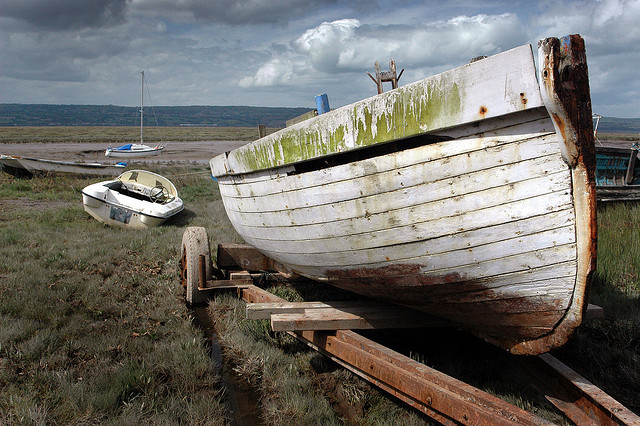

In [ ]:
congruent_count = 0

for i in range(len(similarity_score_list)):
  if similarity_score_list[i] >= 0.5:
    congruent_count += 1

# print(congruent_count)
# print(len(similarity_score_list) - congruent_count)
print("========================== FINAL RESULTS ==========================")
if congruent_count > (len(similarity_score_list) - congruent_count):
  print("OUTPUT: Image and Text pairing are congruous")
else:
  print("OUTPUT: Image and Text pairing are NOT congruous")
print("===================================================================")

print(f"Predicted caption: {output}")
print(f"INPUT text: {input_text}")
print("INPUT Image: ")
Image.open(image_path)